<a href="https://colab.research.google.com/github/The-cheater/Deep_Learning_Models/blob/main/ca_vs_hc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.2 MB/s eta 0:00:00
Mounted at /content/drive


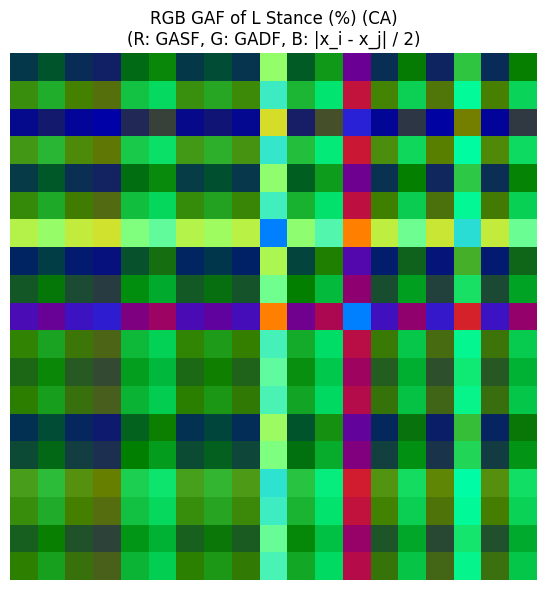

Generated RGB GAF for L Stance (%) (CA): shape=(19, 19, 3)


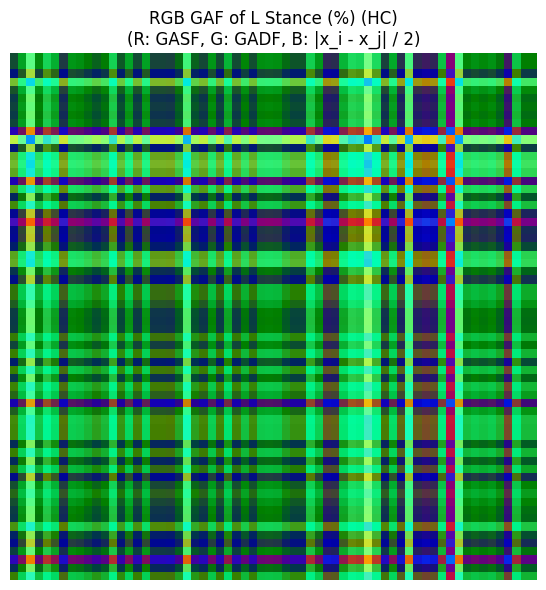

Generated RGB GAF for L Stance (%) (HC): shape=(64, 64, 3)


In [1]:
# Install required packages
!pip install pyts matplotlib scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# STEP 1: Load the datasets
dataset_path = '/content/drive/MyDrive/datasets'
ca_df = pd.read_csv(os.path.join(dataset_path, "CA_gait.csv"))
hc_df = pd.read_csv(os.path.join(dataset_path, "HC_gait.csv"))

# Add labels
ca_df['label'] = 'CA'
hc_df['label'] = 'HC'

# Clean column names
ca_df.columns = ca_df.columns.str.strip().str.replace('\n', '', regex=True)
hc_df.columns = hc_df.columns.str.strip().str.replace('\n', '', regex=True)

# Define features for analysis
features = [
    'R Stance (%)', 'L Stance (%)',
    'R Swing (%)', 'L Swing (%)',
    'R Double Supp. (%)', 'L Double Supp. (%)',
    'R Step Length (m)', 'L Step Length (m)',
    'R Speed (m/s)', 'L Speed (m/s)',
    'R Hip ROM (°)', 'L Hip ROM (°)',
    'R Knee ROM (°)', 'L Knee ROM (°)',
    'R Ankle ROM (°)', 'L Ankle ROM (°)',
    'Cadence (n°step/min)', 'Step Width (m)'
]

# Initialize GAF transformers
gaf_sum = GramianAngularField(method='summation')
gaf_diff = GramianAngularField(method='difference')

# Process each group (CA and HC)
for label, df_label in [('CA', ca_df), ('HC', hc_df)]:
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_label[features])

    # Select feature for GAF
    selected_feature = 'L Stance (%)'
    feature_idx = features.index(selected_feature)
    signal = X_scaled[:, feature_idx]

    # Generate GAF Image
    if signal.size == 0 or not np.isfinite(signal).all():
        print(f"Error: Invalid data for {selected_feature} in {label}")
        continue

    # Normalize to [-1, 1] for GAF
    if np.max(signal) != np.min(signal):
        signal_normalized = 2 * ((signal - np.min(signal)) / (np.max(signal) - np.min(signal))) - 1
    else:
        signal_normalized = np.zeros_like(signal)
        print(f"Warning: {selected_feature} for {label} is constant, normalized to zeros")

    # Apply GASF
    gasf_image = gaf_sum.fit_transform([signal_normalized])[0]

    # Apply GADF
    gadf_image = gaf_diff.fit_transform([signal_normalized])[0]

    # Compute blue channel
    blue_channel = np.abs(signal_normalized[:, None] - signal_normalized[None, :]) / 2

    # Normalize GASF and GADF to [0, 1] for RGB
    gasf_norm = (gasf_image - gasf_image.min()) / (gasf_image.max() - gasf_image.min())
    gadf_norm = (gadf_image - gadf_image.min()) / (gadf_image.max() - gadf_image.min())

    # Create RGB image
    rgb_image = np.zeros((gasf_image.shape[0], gasf_image.shape[1], 3))
    rgb_image[:, :, 0] = gasf_norm  # Red: GASF
    rgb_image[:, :, 1] = gadf_norm  # Green: GADF
    rgb_image[:, :, 2] = blue_channel  # Blue: |x_i - x_j| / 2

    # Visualize RGB GAF image
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image, origin='lower')
    plt.title(f"RGB GAF of {selected_feature} ({label})\n(R: GASF, G: GADF, B: |x_i - x_j| / 2)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Generated RGB GAF for {selected_feature} ({label}): shape={rgb_image.shape}")